In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.table import Table
import pymc3 as pm
import skymotion
import skymotionModified
import skyfield
import corner
from scipy import optimize
from astropy.coordinates import SkyCoord
from tqdm import tqdm
import pickle
import arviz as az
from matplotlib.ticker import StrMethodFormatter

##set random seed
rand_seed = np.random.randint(0,2**32-1)
## note jet angle is defined opposite to convention 
J1820_jet_angle = -26 ## it is 26 in literature
mc_iterations = 100
print("Random seed:", rand_seed)
%matplotlib inline

Random seed: 1709120757


In [2]:
def jet_coordinates(alpha, delta, beta):
    """
    Applying a rotation matrix to transform ra and dec into parallel and perpendicular 
    to jet axis components.
    
    Parameters
    ----------
    alpha: Observation RA, an array, in degrees.
    
    delta: Observation Dec, an array, in degrees.

    beta: rotation angle (jet angle), in degrees.
    
    Returns
    -------    
    theta_perp, theta_para: rotated coordinates, perpendicular and parallel to the jet, respectively (in degrees).
    
    """
    beta_radian = np.radians(beta)
    theta_perp = alpha * np.cos(beta_radian) + delta * np.sin(beta_radian)
    theta_para = delta * np.cos(beta_radian) - alpha * np.sin(beta_radian)
    return theta_perp, theta_para

def mc_normal_sampler(mu, sigma):
    s = np.random.normal(mu, sigma, 10000)
    output = float(np.random.choice(s,1)[0])
    return output

def mc_trace_sampler(trace):
    output  = float(np.random.choice(trace,1)[0])
    return output

def perturbObsBasedOnErr(obs_alpha, obs_alpha_err, obs_delta, obs_delta_err):
    
    output_alpha = []
    output_delta = []
    
    for i in range(len(obs_alpha)):
        output_alpha.append(mc_normal_sampler(obs_alpha[i], obs_alpha_err[i]))
        output_delta.append(mc_normal_sampler(obs_delta[i], obs_delta_err[i]))
        
    return np.array(output_alpha), np.array(output_delta)

### Load data

In [3]:
J1820_data = Table.read("./MAXIJ1820_positions_global_model.txt", format="ascii",names=['MJD','MJD_error','RA','RAs_er','Dec','Decs_er',
                         'Telescope','Band','Calib'])
J1820_calib = Table.read('MAXIJ1820_calib_data.txt',format='ascii')

In [4]:
J1820_calib

Calibrator,Band,offset_RA,offset_RA_er,offset_dec,offset_dec_er,Ion.sys.ra,Ion.sys.dec,sys_VLBA_RA,sys_VLBA_DEC,sys_EVN_RA,sys_EVN_DEC
str5,int64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64
J1821,5,0.0,0.0,0.0,0.0,24,122,36.24,110.31,72.16,23.74
J1821,15,0.0,0.0,0.0,0.0,3,14,36.24,110.31,72.16,23.74
J1813,5,-0.29,0.08,-0.05,0.02,152,82,55.85,101.79,95.63,54.73
J1813,15,-0.29,0.08,-0.05,0.02,17,9,55.85,101.79,95.63,54.73


### Correct for core-shift due to phase ref source

In [5]:
J1820_data.add_column(Table.Column(data=np.full(len(J1820_data), np.nan), name='sys_ra'))
J1820_data.add_column(Table.Column(data=np.full(len(J1820_data), np.nan), name='sys_dec'))

J1820_data.add_column(Table.Column(data=np.full(len(J1820_data), np.nan), name='core_shift_ra'))
J1820_data.add_column(Table.Column(data=np.full(len(J1820_data), np.nan), name='core_shift_dec'))

J1820_data.add_column(Table.Column(data=np.full(len(J1820_data), np.nan), name='core_shift_ra_er'))
J1820_data.add_column(Table.Column(data=np.full(len(J1820_data), np.nan), name='core_shift_dec_er'))

for obs in J1820_data:
    obs_cal = J1820_calib[(J1820_calib['Calibrator'] == obs['Calib']) & (J1820_calib['Band'] == obs['Band'])]
    obs['core_shift_ra'] = obs_cal['offset_RA']
    obs['core_shift_dec'] = obs_cal['offset_dec']
    obs['core_shift_ra_er'] = obs_cal['offset_RA_er']
    obs['core_shift_dec_er'] = obs_cal['offset_dec_er']
    if obs['Telescope'] == 'VLBA':
        obs['sys_ra'] = np.sqrt(obs_cal['sys_VLBA_RA']**2 + obs_cal['Ion.sys.ra']**2)
        obs['sys_dec'] = np.sqrt(obs_cal['sys_VLBA_DEC']**2 + obs_cal['Ion.sys.dec']**2)
    elif obs['Telescope'] == 'EVN':
        obs['sys_ra'] = np.sqrt(obs_cal['sys_EVN_RA']**2 + obs_cal['Ion.sys.ra']**2)
        obs['sys_dec'] = np.sqrt(obs_cal['sys_EVN_DEC']**2 + obs_cal['Ion.sys.dec']**2)


In [6]:
J1820_data


MJD,MJD_error,RA,RAs_er,Dec,Decs_er,Telescope,Band,Calib,sys_ra,sys_dec,core_shift_ra,core_shift_dec,core_shift_ra_er,core_shift_dec_er
float64,float64,str16,float64,str15,float64,str4,int64,str5,float64,float64,float64,float64,float64,float64
58193.65126,0.0577,18:20:21.9386536,1.15e-07,07:11:07.170025,3.81e-06,VLBA,15,J1813,58.37998372730161,102.18710339372576,-0.29,-0.05,0.08,0.02
58397.01055,0.02876,18:20:21.9384875,2.65e-07,07:11:07.166302,9.82e-06,VLBA,15,J1813,58.37998372730161,102.18710339372576,-0.29,-0.05,0.08,0.02
58407.71087,0.15983,18:20:21.9384883,3.164e-06,07:11:07.166075,2.787e-05,EVN,5,J1821,76.04647000354454,124.28832447177008,0.0,0.0,0.0,0.0
58441.72508,0.22508,18:20:21.9384770,8.8e-07,07:11:07.165549,3.088e-05,VLBA,15,J1813,58.37998372730161,102.18710339372576,-0.29,-0.05,0.08,0.02
58457.0423,0.07401,18:20:21.9384371,1.5981e-05,07:11:07.164846,0.00011992,EVN,5,J1821,76.04647000354454,124.28832447177008,0.0,0.0,0.0,0.0
58474.85579,0.05799,18:20:21.9384619,1.3575e-05,07:11:07.164983,0.00040491,VLBA,5,J1821,43.466511247165904,164.47582223536685,0.0,0.0,0.0,0.0
58562.25354,0.157,18:20:21.9384324,1.233e-06,07:11:07.163533,9.09e-06,EVN,5,J1821,76.04647000354454,124.28832447177008,0.0,0.0,0.0,0.0
58718.059,0.02705,18:20:21.9382958,7.68e-07,07:11:07.160872,2.131e-05,VLBA,5,J1821,43.466511247165904,164.47582223536685,0.0,0.0,0.0,0.0
58718.14182,0.04743,18:20:21.9383011,3.42e-07,07:11:07.160709,1.355e-05,VLBA,15,J1821,36.363960180376395,111.1948564457907,0.0,0.0,0.0,0.0


### Modify data to prefered data types

In [7]:
J1820_time = J1820_data['MJD'].data
J1820_alpha = SkyCoord(J1820_data['RA'], J1820_data['Dec'], frame='icrs', unit=(u.hourangle, u.deg)).ra.degree
J1820_delta = SkyCoord(J1820_data['RA'], J1820_data['Dec'], frame='icrs', unit=(u.hourangle, u.deg)).dec.degree
## NOTE: we do not correct alpha for projection (cos(delta)) here and do that inside the MCMC fit
## this is beacuse it is more accurate to correct it during MCMC fit as we then update delta with the core shift as well

## core shifts are in *arcsecs* (NOT SECONDS OF ARC)
J1820_alpha += J1820_data['core_shift_ra'] * 1e-3 / 3600
J1820_delta += J1820_data['core_shift_dec'] * 1e-3 / 3600

J1820_alpha_err = ((J1820_data['RAs_er'].data/ 3600.0 * 15 * np.cos(np.radians(J1820_delta)))**2 + 
                            (J1820_data['sys_ra'].data*1e-6/3600)**2 + 
                            (J1820_data['core_shift_ra_er'].data*1e-6/3600)**2)**0.5

J1820_delta_err = ((J1820_data['Decs_er'].data/ 3600.0)**2 + 
                            (J1820_data['sys_dec'].data*1e-6/3600)**2 + 
                            (J1820_data['core_shift_dec_er'].data*1e-6/3600)**2)**0.5



### make bool mask for C-band data

In [8]:
J1820_mask = []

for freq in J1820_data['Band']:
    if freq == 5:
        J1820_mask.append(True)
    else:
        J1820_mask.append(False)
J1820_mask = np.array(J1820_mask)

### Perform 2D MCMC fitting

In [9]:
with pm.Model() as uniformed_model:
    
    ra_0_guess = J1820_alpha.mean()
    dec_0_guess = J1820_delta.mean()

    
    alpha_0_prior = pm.Uniform('alpha 0', lower=ra_0_guess-0.2/3600, upper=ra_0_guess+0.2/3600)
    delta_0_prior = pm.Uniform('delta 0', lower=dec_0_guess-0.2/3600, upper=dec_0_guess+0.2/3600)
    
    parallax_prior = pm.Uniform('parallax', lower=0.1, upper=0.9)
    pm_alpha_prior = pm.Uniform('pm alpha', lower=-20.0, upper=20.0)
    pm_delta_prior = pm.Uniform('pm delta', lower=-20.0, upper=20.0)
        
    ra_core_shift_prior = pm.Uniform('ra shift', lower=-1, upper=1) ## in deg (to prevent chain failing)
    dec_core_shift_prior = pm.Uniform('dec shift', lower=-1, upper=1) ## in deg
    
    
    # orbital components:
    orb_Omega_prior = 0                                                                           # In degrees
    orb_a_prior = 0                                                                               # In milliarcsec
    orb_omega_prior = 0                                                                           # In degrees
    orb_i_prior = 0                                                                               # In degrees
    orb_T_0_prior = 0                                                                             # MJD
    orb_P_prior = 0                                                                               # in days
    orb_e_prior = 0                                                                               # unitless
    
    #####
    
    ## apply core shift to obs
    J1820_alpha_coreshifted = J1820_alpha + J1820_mask*ra_core_shift_prior
    J1820_delta_coreshifted = J1820_delta + J1820_mask*dec_core_shift_prior    
    # Expected values for RA and Dec:
    
    expected_ra, expected_dec = skymotionModified.total_motion(t = J1820_time,
                                             alpha = J1820_alpha_coreshifted,
                                             delta = J1820_delta_coreshifted,
                                             alpha_0 = alpha_0_prior,
                                             delta_0 = delta_0_prior,
                                             pm_alpha = pm_alpha_prior,
                                             pm_delta = pm_delta_prior,
                                             parallax = parallax_prior,
                                             orb_T_0 = orb_T_0_prior,
                                             orb_P = orb_P_prior,
                                             orb_e = orb_e_prior,
                                             orb_i = orb_i_prior,
                                             orb_omega = orb_omega_prior,
                                             orb_Omega = orb_Omega_prior,
                                             orb_a = orb_a_prior,
                                             binary_orbit = False)
    
    # Observed quantities:
    fitting_ra = pm.Normal('ra', mu = expected_ra, 
                           sd = J1820_alpha_err * np.cos(J1820_delta_coreshifted*np.pi/180), 
                           observed = J1820_alpha_coreshifted * np.cos(J1820_delta_coreshifted*np.pi/180))
    
    fitting_dec = pm.Normal('dec', mu = expected_dec, 
                            sd = J1820_delta_err, 
                            observed = J1820_delta_coreshifted)
    step_method = pm.NUTS()
    J1820_trace_2D = pm.sample(10000, chains=12, cores=12, tune=1000, random_seed=rand_seed, step=step_method)
    


/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:60: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [dec shift, ra shift, pm delta, pm alpha, parallax, delta 0, alpha 0]


Sampling 12 chains for 1_000 tune and 10_000 draw iterations (12_000 + 120_000 draws total) took 46 seconds.


/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: invalid value encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimati

array([[<AxesSubplot:title={'center':'alpha 0'}>,
        <AxesSubplot:title={'center':'alpha 0'}>],
       [<AxesSubplot:title={'center':'delta 0'}>,
        <AxesSubplot:title={'center':'delta 0'}>],
       [<AxesSubplot:title={'center':'parallax'}>,
        <AxesSubplot:title={'center':'parallax'}>],
       [<AxesSubplot:title={'center':'pm alpha'}>,
        <AxesSubplot:title={'center':'pm alpha'}>],
       [<AxesSubplot:title={'center':'pm delta'}>,
        <AxesSubplot:title={'center':'pm delta'}>],
       [<AxesSubplot:title={'center':'ra shift'}>,
        <AxesSubplot:title={'center':'ra shift'}>],
       [<AxesSubplot:title={'center':'dec shift'}>,
        <AxesSubplot:title={'center':'dec shift'}>]], dtype=object)

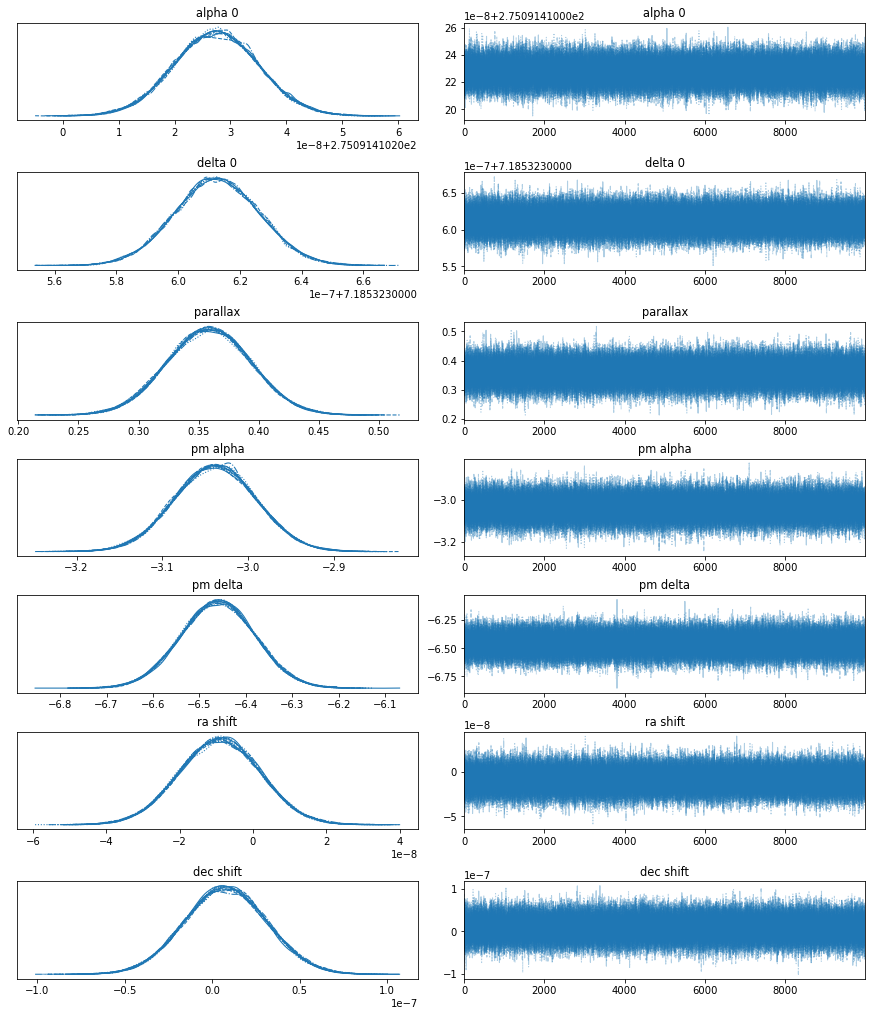

In [10]:
pm.traceplot(J1820_trace_2D)

In [11]:
pm.summary(J1820_trace_2D)

/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha 0,275.091,0.000,275.091,275.091,0.0,0.0,110720.0,91879.0,1.0
delta 0,7.185,0.000,7.185,7.185,0.0,0.0,121431.0,91505.0,1.0
parallax,0.359,0.035,0.294,0.425,0.0,0.0,97082.0,83893.0,1.0
pm alpha,-3.038,0.048,-3.129,-2.950,0.0,0.0,109684.0,91545.0,1.0
pm delta,-6.460,0.080,-6.609,-6.309,0.0,0.0,138284.0,85056.0,1.0
ra shift,-0.000,0.000,-0.000,0.000,0.0,0.0,118056.0,93978.0,1.0
dec shift,0.000,0.000,-0.000,0.000,0.0,0.0,118224.0,93794.0,1.0


In [12]:
print("The determined core-shift for J1820 offsets are")
print('ra  nu : {} mas'.format(np.median(J1820_trace_2D['ra shift'])*3.6e6))
print('ra  sd : {} mas'.format(np.std(J1820_trace_2D['ra shift'])*3.6e6))
print('dec nu : {} mas'.format(np.median(J1820_trace_2D['dec shift'])*3.6e6))
print('dec sd : {} mas'.format(np.std(J1820_trace_2D['dec shift'])*3.6e6))

The determined core-shift for J1820 offsets are
ra  nu : -0.03243247990170062 mas
ra  sd : 0.039825031520244275 mas
dec nu : 0.027334863172967516 mas
dec sd : 0.0845639156403318 mas


### Update alpha and delta based on core-shift

In [13]:
J1820_alpha_coreshifted = J1820_alpha + J1820_mask*np.median(J1820_trace_2D['ra shift'])
J1820_delta_coreshifted = J1820_delta + J1820_mask*np.median(J1820_trace_2D['dec shift'])
## add errors in quadrature
J1820_alpha_err_coreshifted = np.sqrt(J1820_alpha_err**2 + np.std(J1820_trace_2D['ra shift'])**2)
J1820_delta_err_coreshifted = np.sqrt(J1820_delta_err**2 + np.std(J1820_trace_2D['dec shift'])**2)

### Perform 1D MCMC fitting

In [14]:
J1820_theta_perp_t, J1820_theta_para_t = jet_coordinates(J1820_alpha_coreshifted * np.cos(np.radians(J1820_delta_coreshifted))\
                                             , J1820_delta_coreshifted, J1820_jet_angle)
J1820_theta_perp_er = np.sqrt((J1820_alpha_err_coreshifted * np.cos(np.radians(J1820_jet_angle)))**2\
                        + (J1820_delta_err_coreshifted * np.sin(np.radians(J1820_jet_angle)))**2)
J1820_theta_para_er = np.sqrt((J1820_alpha_err_coreshifted * np.sin(np.radians(J1820_jet_angle)))**2\
                        + (J1820_delta_err_coreshifted * np.cos(np.radians(J1820_jet_angle)))**2)


with pm.Model() as projection_model:
    
    ra_0_guessXC = J1820_alpha.mean()
    dec_0_guessXC = J1820_delta.mean()
    


    alpha_0_prior = pm.Normal('alpha 0',
                              mu=J1820_trace_2D.get_values('alpha 0').mean(),
                              sd=J1820_trace_2D.get_values('alpha 0').std())
    delta_0_prior = pm.Normal('delta 0',
                              mu=J1820_trace_2D.get_values('delta 0').mean(),
                              sd=J1820_trace_2D.get_values('delta 0').std())
    
    parallax_prior = pm.Normal('parallax',
                              mu=J1820_trace_2D.get_values('parallax').mean(),
                              sd=J1820_trace_2D.get_values('parallax').std())
    pm_alpha_prior = pm.Normal('pm alpha', 
                               mu=J1820_trace_2D.get_values('pm alpha').mean(),
                               sd=J1820_trace_2D.get_values('pm alpha').std())                      # In milliarcsec/yr
    
    pm_delta_prior = pm.Normal('pm delta', 
                               mu=J1820_trace_2D.get_values('pm delta').mean(),
                               sd=J1820_trace_2D.get_values('pm delta').std())                      # In milliarcsec/yr
    
#     ra_core_shift_prior = pm.Normal('ra shift',
#                                     mu=V404_trace_2D.get_values('ra shift').mean(),
#                                     sd=V404_trace_2D.get_values('ra shift').std()) ## in deg (to prevent chain failing)
#     dec_core_shift_prior = pm.Normal('dec shift', 
#                                      mu=V404_trace_2D.get_values('dec shift').mean(),
#                                      sd=V404_trace_2D.get_values('dec shift').std()) ## in deg
    
    
    # orbital components:
    orb_Omega_prior = 0                                                                           # In degrees
    orb_a_prior = 0                                                                               # In milliarcsec
    orb_omega_prior = 0                                                                           # In degrees
    orb_i_prior = 0                                                                               # In degrees
    orb_T_0_prior = 0                                                                             # MJD
    orb_P_prior = 0                                                                               # in days
    orb_e_prior = 0                                                                               # unitless
    #####
    
    ## apply core shift to obs
    #V404_alpha_coreshifted = V404_alphaXC + V404_maskXC*ra_core_shift_prior
    #V404_delta_coreshifted = V404_deltaXC + V404_maskXC*dec_core_shift_prior
    
    
    # Expected values for RA and Dec:
    # expected_ra, expected_dec = skymotionModified.total_motion(t = V404_timeXC,
    #                                          alpha = V404_alpha_coreshifted,
    #                                          delta = V404_delta_coreshifted,
    #                                          alpha_0 = alpha_0_prior,
    #                                          delta_0 = delta_0_prior,
    #                                          pm_alpha = pm_alpha_prior,
    #                                          pm_delta = pm_delta_prior,
    #                                          parallax = parallax_prior,
    #                                          orb_T_0 = orb_T_0_prior,
    #                                          orb_P = orb_P_prior,
    #                                          orb_e = orb_e_prior,
    #                                          orb_i = orb_i_prior,
    #                                          orb_omega = orb_omega_prior,
    #                                          orb_Omega = orb_Omega_prior,
    #                                          orb_a = orb_a_prior,
    #                                          binary_orbit = False)
    
    
    
    expected_ra, expected_dec = skymotionModified.total_motion(t = J1820_time,
                                             alpha = J1820_alpha_coreshifted,
                                             delta = J1820_delta_coreshifted,
                                             alpha_0 = alpha_0_prior,
                                             delta_0 = delta_0_prior,
                                             pm_alpha = pm_alpha_prior,
                                             pm_delta = pm_delta_prior,
                                             parallax = parallax_prior,
                                             orb_T_0 = orb_T_0_prior,
                                             orb_P = orb_P_prior,
                                             orb_e = orb_e_prior,
                                             orb_i = orb_i_prior,
                                             orb_omega = orb_omega_prior,
                                             orb_Omega = orb_Omega_prior,
                                             orb_a = orb_a_prior,
                                             binary_orbit = False)
    
    
    expected_theta_perp, expected_theta_para = jet_coordinates(expected_ra, expected_dec, J1820_jet_angle)
    
    # Observed quantities:  
    fitting_theta_perp = pm.Normal('theta_perp', mu = expected_theta_perp,
                                   sd = J1820_theta_perp_er,
                                   observed = J1820_theta_perp_t)

    step_method = pm.NUTS()
    J1820_trace_1D = pm.sample(10000, chains=12, cores=12, tune=1000, random_seed=rand_seed, step=step_method)
    

    


/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:103: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [pm delta, pm alpha, parallax, delta 0, alpha 0]


Sampling 12 chains for 1_000 tune and 10_000 draw iterations (12_000 + 120_000 draws total) took 29 seconds.


/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: invalid value encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimati

array([[<AxesSubplot:title={'center':'alpha 0'}>,
        <AxesSubplot:title={'center':'alpha 0'}>],
       [<AxesSubplot:title={'center':'delta 0'}>,
        <AxesSubplot:title={'center':'delta 0'}>],
       [<AxesSubplot:title={'center':'parallax'}>,
        <AxesSubplot:title={'center':'parallax'}>],
       [<AxesSubplot:title={'center':'pm alpha'}>,
        <AxesSubplot:title={'center':'pm alpha'}>],
       [<AxesSubplot:title={'center':'pm delta'}>,
        <AxesSubplot:title={'center':'pm delta'}>]], dtype=object)

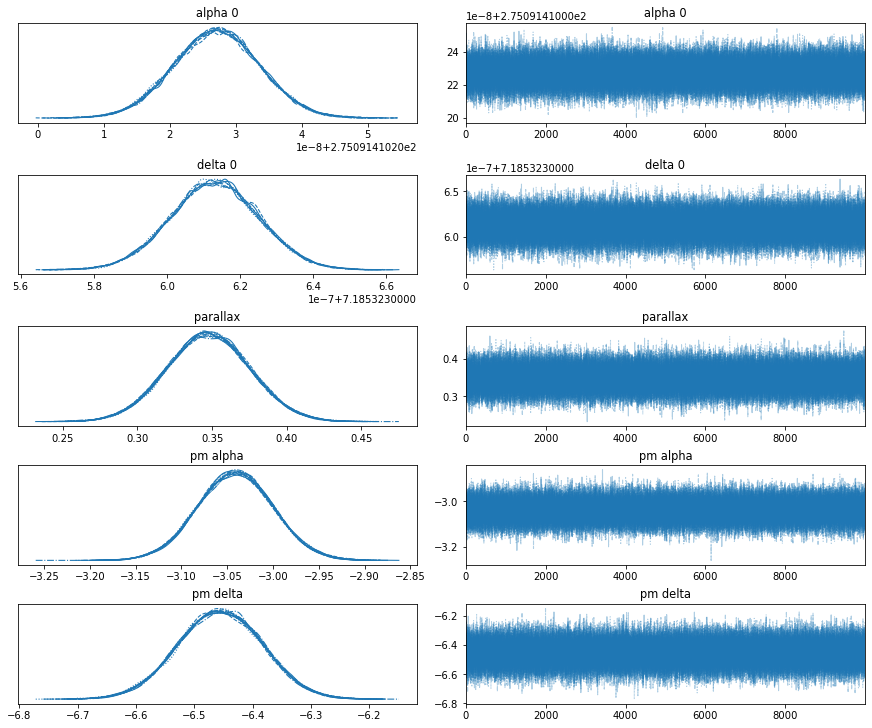

In [15]:
pm.traceplot(J1820_trace_1D)

In [16]:
pm.summary(J1820_trace_1D).round(10)

/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha 0,275.091,0.000,275.091,275.091,0.0,0.0,135737.0,101800.0,1.0
delta 0,7.185,0.000,7.185,7.185,0.0,0.0,140333.0,102712.0,1.0
parallax,0.348,0.028,0.296,0.400,0.0,0.0,134095.0,100208.0,1.0
pm alpha,-3.041,0.041,-3.118,-2.964,0.0,0.0,134398.0,101060.0,1.0
pm delta,-6.456,0.072,-6.593,-6.321,0.0,0.0,138638.0,100480.0,1.0


In [17]:
az.hdi(J1820_trace_1D['pm alpha'], hdi_prob=.68)

array([-3.08225584, -3.00071718])

### astrometry plot

100%|██████████| 100/100 [00:01<00:00, 95.90it/s]
/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/arviz/stats/stats.py:459: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


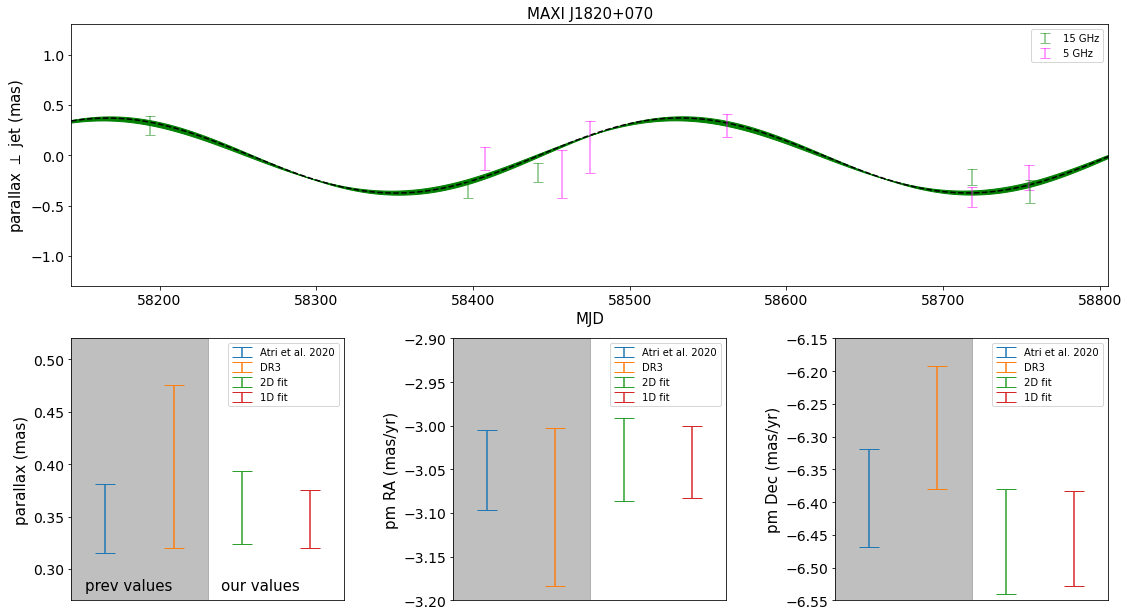

In [46]:
hfont = {'fontname':'Helvetica', 'size':15}

J1820_c_band_mask = np.invert(np.copy(J1820_mask))
J1820_ra_residual_trace = []
J1820_dec_residual_trace = []
J1820_ra_parallax_signal_trace = []
J1820_dec_parallax_signal_trace = []
J1820_perp_trace = []
J1820_para_trace = []

for i in tqdm(range(mc_iterations)):
    
    ## perturb observation
    J1820_alpha, J1820_delta = perturbObsBasedOnErr(J1820_alpha_coreshifted, J1820_alpha_err_coreshifted,\
                                                J1820_delta_coreshifted, J1820_delta_err_coreshifted)
    
    J1820_time = np.copy(J1820_time)
    
    ## perturb proper motion and parallax
    pm_alpha_deg = mc_trace_sampler(J1820_trace_1D['pm alpha']) / 3.6e6 / 365.25    
    pm_delta_deg = mc_trace_sampler(J1820_trace_1D['pm delta']) / 3.6e6 / 365.25    
    parallax_deg = mc_trace_sampler(J1820_trace_1D['parallax']) / 3.6e6
    alpha_0 = mc_trace_sampler(J1820_trace_1D['alpha 0'])
    delta_0 = mc_trace_sampler(J1820_trace_1D['delta 0'])
    
    ## compute proper motion and residuals
    frac_alpha, frac_delta = skymotion.frac_parallax(J1820_time, J1820_alpha, J1820_delta)
    ref_t = skymotion.t_0(J1820_time)
    fit_ra_proper = alpha_0 * np.cos(np.radians(J1820_delta)) + (pm_alpha_deg * (J1820_time - ref_t))
    fit_dec_proper = delta_0 + (pm_delta_deg * (J1820_time - ref_t))
    fit_ra = fit_ra_proper + frac_alpha * parallax_deg
    fit_dec = fit_dec_proper + frac_delta * parallax_deg
    
    J1820_ra_parallax_signal_trace.append(J1820_alpha* np.cos(np.radians(J1820_delta)) - fit_ra_proper)
    J1820_dec_parallax_signal_trace.append(J1820_delta - fit_dec_proper)
    J1820_ra_residual_trace.append(J1820_alpha* np.cos(np.radians(J1820_delta)) - fit_ra)
    J1820_dec_residual_trace.append(J1820_delta - fit_dec)
    
    ra = J1820_alpha* np.cos(np.radians(J1820_delta)) - fit_ra_proper
    dec = J1820_delta - fit_dec_proper
    perp_t, para_t = jet_coordinates(ra, dec, J1820_jet_angle)
    J1820_perp_trace.append(perp_t)
    J1820_para_trace.append(para_t)
    
    
    

time_array = np.linspace(np.min(J1820_time)-50, np.max(J1820_time)+50, 200)

frac_alpha, frac_delta = skymotion.frac_parallax(time_array, np.mean(J1820_trace_1D['alpha 0']), \
                                                 np.mean(J1820_trace_1D['delta 0']) )

parallax_deg = np.mean(J1820_trace_1D['parallax'])
theta_perp_t, theta_para_t = jet_coordinates(frac_alpha * np.cos(np.radians(frac_delta))*parallax_deg\
                                             , frac_delta, J1820_jet_angle)
    
fig = plt.figure(figsize=(18,10))

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.2)

plt.subplot(2,1,1)
plt.plot(time_array, theta_perp_t, color="black", linestyle="dashed", zorder=2)
plt.xlim(min(time_array), max(time_array))

theta_perp_t_global_trace = []

for i in range(1000):
    frac_alpha, frac_delta = skymotion.frac_parallax(time_array, mc_trace_sampler(J1820_trace_1D['alpha 0']), \
                                                 mc_trace_sampler(J1820_trace_1D['delta 0']) )

    parallax_deg = mc_trace_sampler(J1820_trace_1D['parallax'])
    theta_perp_t, theta_para_t = jet_coordinates(frac_alpha * np.cos(np.radians(frac_delta))*parallax_deg\
                                             , frac_delta, J1820_jet_angle)
    theta_perp_t_global_trace.append(theta_perp_t)

upper_limit, lower_limit = az.hdi(np.array(theta_perp_t_global_trace), hdi_prob=.68).T
plt.fill_between(time_array,upper_limit, lower_limit, alpha=1, color='green', zorder=1)


for x, y, z, label in zip(J1820_time, np.mean(J1820_perp_trace, axis=0)*3.6e6,np.std(J1820_perp_trace, axis=0)*3.6e6, J1820_data['Band']):
    
    if label == 5:
        plt.errorbar(x, y, yerr=z, fmt=" ", capsize=5, color='magenta', alpha=0.5, label="5 GHz")
    else:
        plt.errorbar(x, y, yerr=z, fmt=" ", capsize=5, color='green', alpha=0.5, label="15 GHz")

#plt.errorbar(V404_timeXC, np.mean(V404_perp_trace, axis=0)*3.6e6, 
#             yerr=np.std(V404_perp_trace, axis=0)*3.6e6, fmt=" ", capsize=5)

plt.ylim(-1.3, 1.3)
plt.ylabel(r'parallax $\perp$ jet (mas)', **hfont)
plt.xlabel("MJD",**hfont)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title('MAXI J1820+070',**hfont)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)


# ax1 = fig.add_subplot(323)
# plt.errorbar(np.median(J1820_ra_residual_trace, axis=0)*3.6e6*J1820_c_band_mask, np.median(J1820_dec_residual_trace, axis=0)*3.6e6*J1820_c_band_mask,\
#              xerr=np.std(J1820_ra_residual_trace, axis=0)*3.6e6*J1820_c_band_mask, yerr=np.std(J1820_dec_residual_trace, axis=0)*3.6e6*J1820_c_band_mask,\
#              fmt=' ', capsize=5,color="green", alpha=0.5)


# x_array = np.linspace(-1.5, 1.5, 10)
# y_array = x_array*np.tan(np.radians(J1820_jet_angle + 90))
# plt.plot(x_array, y_array, color="red", label=r'$64*{\circ}$ jet axis')
# plt.title("Ku-Band residuals",**hfont)
# plt.xlabel("residual (mas)",**hfont)
# plt.ylabel("residual (mas)",**hfont)
# plt.xlim(0.4, -0.4)
# plt.ylim(-0.4, 0.4)
# plt.legend()
# plt.hlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)
# plt.vlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)


# ax2 = fig.add_subplot(324)
# plt.errorbar(np.median(J1820_ra_residual_trace, axis=0)*3.6e6*J1820_mask, np.median(J1820_dec_residual_trace, axis=0)*3.6e6*J1820_mask,\
#              xerr=np.std(J1820_ra_residual_trace, axis=0)*3.6e6*J1820_mask, yerr=np.std(J1820_dec_residual_trace, axis=0)*3.6e6*J1820_mask,\
#              fmt=' ', capsize=5,color="magenta", alpha=0.5)


# x_array = np.linspace(-1.5, 1.5, 10)
# y_array = x_array*np.tan(np.radians(J1820_jet_angle + 90))
# plt.plot(x_array, y_array, color="red", label=r'$64^{\circ}$ jet axis')
# plt.title("C-Band residuals",**hfont)
# plt.xlabel("residual (mas)",**hfont)
# plt.ylabel("residual (mas)",**hfont)
# plt.xlim(1, -1)
# plt.ylim(-1, 1)
# plt.legend()
# plt.hlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)
# plt.vlines(0, -2, 2, color='black', linestyle='dashed', alpha=0.5)

# ax1.set_aspect('equal')
# ax2.set_aspect('equal')


ax3 = plt.subplot(234)
plt.errorbar(1, 0.348, yerr=0.033, label="Atri et al. 2020", capsize=10, fmt=' ')
plt.errorbar(2, 0.3978309267225294, yerr=0.07798400521278381, label="DR3", capsize=10, fmt=' ')
plt.errorbar(3, np.mean(J1820_trace_2D["parallax"]), yerr=np.std(J1820_trace_2D["parallax"]), capsize=10, label="2D fit", fmt=' ')
plt.errorbar(4, np.mean(J1820_trace_1D["parallax"]), yerr=np.std(J1820_trace_1D["parallax"]), capsize=10, label="1D fit", fmt=' ')
ax3.axvspan(0, 2.5, ymin=0, ymax=1, alpha=0.5, color='grey')
plt.legend()
plt.ylim(0.27, 0.52)
plt.xlim(0.5, 4.5)
plt.ylabel("parallax (mas)",**hfont)
plt.text(0.7, 0.28, 'prev values',**hfont)
plt.text(2.7, 0.28, 'our values',**hfont)
plt.xticks([]) 
plt.yticks(fontsize=14)



ax4 = plt.subplot(236)
plt.errorbar(1, -6.394, yerr=0.075, label="Atri et al. 2020", capsize=10, fmt=' ')
plt.errorbar(2, -6.285706339181691, yerr=0.0942222997546196, capsize=10, label="DR3", fmt=' ')
plt.errorbar(3, np.mean(J1820_trace_2D["pm delta"]), yerr=np.std(J1820_trace_2D["pm delta"]), capsize=10, label="2D fit", fmt=' ')
plt.errorbar(4, np.mean(J1820_trace_1D["pm delta"]), yerr=np.std(J1820_trace_1D["pm delta"]), capsize=10, label="1D fit", fmt=' ')
plt.legend()
plt.ylabel("pm Dec (mas/yr)",**hfont)
ax4.axvspan(0, 2.5, ymin=1, ymax=0, alpha=0.5, color='grey')
plt.ylim(-6.55, -6.15)
plt.xlim(0.5, 4.5)
plt.xticks([]) 
plt.yticks(fontsize=14)



ax5 = plt.subplot(235)
plt.errorbar(1, -3.051, yerr=0.046, label="Atri et al. 2020", capsize=10, fmt=' ')
plt.errorbar(2, -3.092926397092064, yerr=0.09064880013465881, label="DR3", capsize=10, fmt=' ')
plt.errorbar(3, np.mean(J1820_trace_2D["pm alpha"]), yerr=np.std(J1820_trace_2D["pm alpha"]), capsize=10, label="2D fit", fmt=' ')
plt.errorbar(4, np.mean(J1820_trace_1D["pm alpha"]), yerr=np.std(J1820_trace_1D["pm alpha"]), capsize=10, label="1D fit", fmt=' ')
plt.legend()
plt.ylabel("pm RA (mas/yr)",**hfont)
ax5.axvspan(0, 2.5, ymin=1, ymax=0, alpha=0.5, color='grey')
plt.xlim(0.5, 4.5)
plt.xticks([]) 
plt.yticks(fontsize=14)
plt.ylim(-3.2, -2.9)
#plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) 

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.savefig('1820results.png')

In [19]:
print("parallx {}nu {}std".format(np.mean(J1820_trace_1D["parallax"]), np.std(J1820_trace_1D["parallax"])))
print("pm alpha {}nu {}std".format(np.mean(J1820_trace_1D["pm alpha"]), np.std(J1820_trace_1D["pm alpha"])))
print("pm delta {}nu {}std".format(np.mean(J1820_trace_1D["pm delta"]), np.std(J1820_trace_1D["pm delta"])))

parallx 0.3475449813383838nu 0.027732998264707057std
pm alpha -3.041202079028263nu 0.04105802094753284std
pm delta -6.455833333023046nu 0.07249659013409072std


### Calculate BH orbit radius

In [20]:
def getBHorbit(P, M1, M2):
    
    G = 6.6743E-11
    omega = 2*np.pi/(P*60*60)
    a = ((G*M2**3)/(omega**2*(M1+M2)**2))**(1/3)
    return a
    

M0 = 1.989E+30
P = 16.4518 #hrs
dist = 2.96 #kpc
M1 = 7.5*M0 #solar mass
M2 = 0.07*M1


a = getBHorbit(P, M1, M2)
print('orbit radius {:.2E}m'.format(a))


dist_SI = dist*1000*3.086e+16
#calculate theta based on s=rxtheta
theta = np.degrees(a/dist_SI)*3600*1000
print('theta {:.2E}mas'.format(theta))

orbit radius 2.98E+08m
theta 6.73E-04mas


### project coreshift into upper limit on jet size (au)

In [21]:
jet_size_trace_sky = []
jet_size_trace_jetdirection = []

parsec2au = 206265

for i in tqdm(range(1000)):
    ra_coreshift = mc_trace_sampler(J1820_trace_2D['ra shift'])*3.6e6 #mas
    dec_coreshift = mc_trace_sampler(J1820_trace_2D['dec shift'])*3.6e6 #mas
    
    cs_theta_perp_t, cs_theta_para_t = jet_coordinates(ra_coreshift\
                                             , dec_coreshift, J1820_jet_angle)

    
    #total_coreshift = np.sqrt(ra_coreshift**2 + dec_coreshift**2)
    total_coreshift = cs_theta_para_t
    core_shift_radians = np.radians(total_coreshift*1e-3/3600) ## mas to rad
    
    ## get distance to source (in au as final product)
    parallax = mc_trace_sampler(J1820_trace_1D["parallax"])*1e-3 #asec
    dist_parsec = 1/parallax
    dist_au = dist_parsec*parsec2au
    
    #s=rxtheta
    jet_size_skyplane = dist_au*core_shift_radians #units au
    
    ## reproject along the jet axis
    jet_size_jetdirection = jet_size_skyplane/np.sin(np.radians(63))
    
    jet_size_trace_sky.append(jet_size_skyplane)
    jet_size_trace_jetdirection.append(jet_size_jetdirection)

100%|██████████| 1000/1000 [00:00<00:00, 3320.62it/s]


(0.0, 300.0)

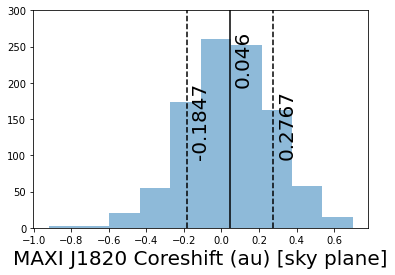

In [22]:

plt.hist(jet_size_trace_sky, alpha=0.5)
plt.xlabel('MAXI J1820 Coreshift (au) [sky plane]', **hfont)


plt.vlines(np.median(jet_size_trace_sky) - np.std(jet_size_trace_sky), 0, 550, color='black', linestyle='dashed')
plt.vlines(np.median(jet_size_trace_sky) + np.std(jet_size_trace_sky), 0, 550, color='black', linestyle='dashed')
plt.vlines(np.median(jet_size_trace_sky), 0, 550, color='black')
var = np.copy(jet_size_trace_sky)
plt.text(np.median(var)+0.02, 200, round(np.median(var),4), rotation=90, **hfont)
plt.text(np.median(var)+np.std(var)+0.02, 100, round(np.median(var)+np.std(var),4), rotation=90, **hfont)
plt.text(np.median(var)-np.std(var)+0.02, 100, round(np.median(var)-np.std(var),4), rotation=90, **hfont)

plt.ylim(0, 300)

## save trace to disk

In [23]:
with open('18202Dtrace.pickle', 'wb') as handle:
    pickle.dump(J1820_trace_2D, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('18201Dtrace.pickle', 'wb') as handle:
    pickle.dump(J1820_trace_1D, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
np.arcsin(1)

1.5707963267948966

Text(0, 0.5, 'counts')

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


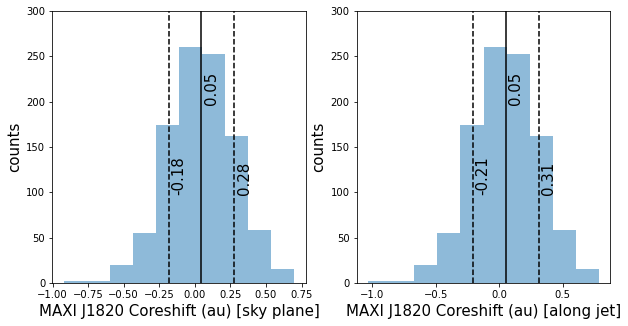

In [25]:
plt.figure(figsize=(10,5))
hfont = {'fontname':'Helvetica', 'size':15}

plt.subplot(121)
plt.hist(jet_size_trace_sky, alpha=0.5)
plt.xlabel('MAXI J1820 Coreshift (au) [sky plane]', **hfont)
plt.vlines(np.median(jet_size_trace_sky) - np.std(jet_size_trace_sky), 0, 550, color='black', linestyle='dashed')
plt.vlines(np.median(jet_size_trace_sky) + np.std(jet_size_trace_sky), 0, 550, color='black', linestyle='dashed')
plt.vlines(np.median(jet_size_trace_sky), 0, 550, color='black')
var = np.copy(jet_size_trace_sky)
plt.text(np.median(var)+0.02, 200, round(np.median(var),2), rotation=90, **hfont)
plt.text(np.median(var)+np.std(var)+0.02, 100, round(np.median(var)+np.std(var),2), rotation=90, **hfont)
plt.text(np.median(var)-np.std(var)+0.02, 100, round(np.median(var)-np.std(var),2), rotation=90, **hfont)
plt.ylim(0, 300)
plt.ylabel('counts',**hfont)

plt.subplot(122)
plt.hist(jet_size_trace_jetdirection, alpha=0.5)
plt.xlabel('MAXI J1820 Coreshift (au) [along jet]', **hfont)
plt.vlines(np.median(jet_size_trace_jetdirection) - np.std(jet_size_trace_jetdirection), 0, 550, color='black', linestyle='dashed')
plt.vlines(np.median(jet_size_trace_jetdirection) + np.std(jet_size_trace_jetdirection), 0, 550, color='black', linestyle='dashed')
plt.vlines(np.median(jet_size_trace_jetdirection), 0, 550, color='black')
var = np.copy(jet_size_trace_jetdirection)
plt.text(np.median(var)+0.02, 200, round(np.median(var),2), rotation=90, **hfont)
plt.text(np.median(var)+np.std(var)+0.02, 100, round(np.median(var)+np.std(var),2), rotation=90, **hfont)
plt.text(np.median(var)-np.std(var)+0.02, 100, round(np.median(var)-np.std(var),2), rotation=90, **hfont)
plt.ylim(0, 300)
plt.ylabel('counts',**hfont)


In [26]:
J1820_trace_1D['parallax']

array([0.34976921, 0.35037689, 0.32753629, ..., 0.3358259 , 0.32880284,
       0.34005734])